In [1]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, geom_smooth, geom_bar,
    aes, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import patchworklib as pw
import numpy as np
from llm_ran.benchmark.metrics import pass_at, pass_power

<Figure size 100x100 with 0 Axes>

In [2]:
DATA_PATH = "../data"
OUTPUT_PATH = "../../thesis/figures"

mainline_models = [
    "qwen2.5:32b",
    "qwen2.5-coder:32b",
    # "mixtral:8x22b",
    "sky-t1:32b",
    "qwq:32b",
]

df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[df['model'].isin(mainline_models)]
df = df.rename(columns={"chain": "agent"})
df.columns

Index(['scenario', 'question', 'trial', 'run_id', 'model', 'agent',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'pass', 'deviation'],
      dtype='object')

In [4]:
group_by = ["model", "agent"]
metrics = ["can_answer", "correct", "pass"]
agg = {
    "can_answer@1": ('can_answer', pass_at(1)),
    "can_answer@5": ('can_answer', pass_at(5)),
    "can_answer^5": ('can_answer', pass_power(5)),
    "correct@1": ('correct', pass_at(1)),
    "correct@5": ('correct', pass_at(5)),
    "correct^5": ('correct', pass_power(5)),
    "pass@1": ('pass', pass_at(1)),
    "pass@5": ('pass', pass_at(5)),
    "pass^5": ('pass', pass_power(5)),
}
resampled = df.groupby(group_by)[metrics].agg(**agg).reset_index()
display(resampled)
pivoted = resampled.melt(
    id_vars=group_by,
    value_vars=agg.keys(),
    var_name="metric",
    value_name="value",
)
# display(pivoted)

,model,agent,can_answer@1,can_answer@5,can_answer^5,correct@1,correct@5,correct^5,pass@1,pass@5,pass^5
0,qwen2.5-coder:32b,codegen,0.896721,0.999990,0.579812,0.662295,0.995748,0.127426,0.649180,0.994846,0.115299
1,qwen2.5-coder:32b,direct,0.929508,0.999999,0.693851,0.449180,0.949973,0.018285,0.442623,0.946905,0.016989
2,qwen2.5:32b,codegen,0.626230,0.992904,0.096309,0.665574,0.995952,0.130611,0.495082,0.967710,0.029743
3,qwen2.5:32b,direct,0.824590,0.999846,0.381233,0.722951,0.998437,0.197489,0.655738,0.995315,0.121241
4,qwq:32b,codegen,0.875410,0.999973,0.514111,0.786885,0.999587,0.301687,0.783607,0.999553,0.295454
5,qwq:32b,direct,0.963934,1.000000,0.832219,0.732787,0.998698,0.211295,0.732787,0.998698,0.211295
6,sky-t1:32b,codegen,0.306557,0.840821,0.002707,0.437705,0.944507,0.016066,0.240984,0.749399,0.000813
7,sky-t1:32b,direct,0.622951,0.992585,0.093814,0.673770,0.996429,0.138854,0.513115,0.973111,0.035569


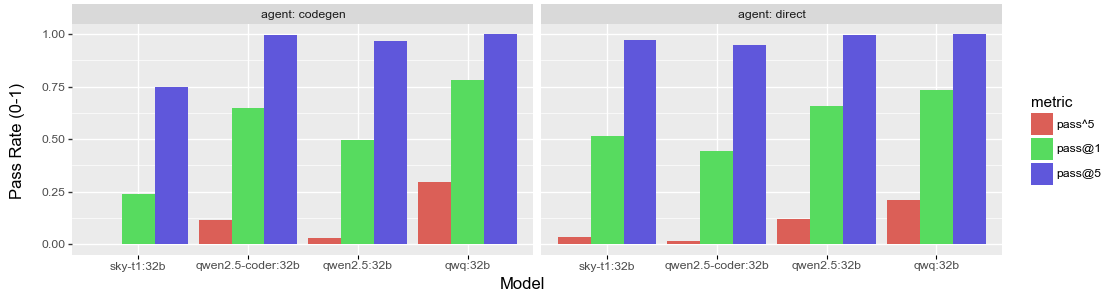

<Figure size 640x480 with 0 Axes>

In [6]:
_g1 = (
    ggplot(pivoted[pivoted["metric"].str.startswith("pass")], aes(x="reorder(model, value)", y="value", fill="reorder(metric, value)"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("~agent", labeller="label_both")
    + labs(
        x="Model",
        y="Pass Rate (0-1)",
        fill="metric",
        # title="Pass Rate",
    )
)

_figsize = (12, 3)
_g = pw.load_ggplot(_g1, figsize=_figsize)
_g.savefig(f"{OUTPUT_PATH}/overview_performance.png", bbox_inches="tight")

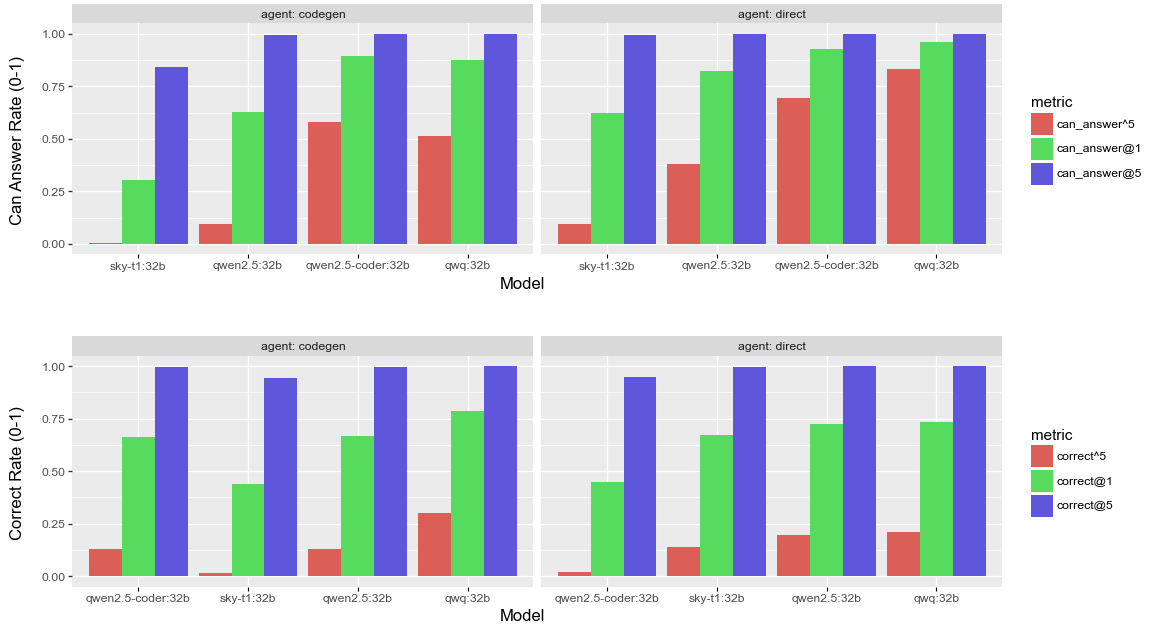

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
_g1 = (
    ggplot(pivoted[pivoted["metric"].str.startswith("can_answer")], aes(x="reorder(model, value)", y="value", fill="reorder(metric, value)"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("~agent", labeller="label_both")
    + labs(
        x="Model",
        y="Can Answer Rate (0-1)",
        fill="metric",
        # title="Can Answer Rate",
    )
)
_g2 = (
    ggplot(pivoted[pivoted["metric"].str.startswith("correct")], aes(x="reorder(model, value)", y="value", fill="reorder(metric, value)"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("~agent", labeller="label_both")
    + labs(
        x="Model",
        y="Correct Rate (0-1)",
        fill="metric",
        # title="Correct Rate",
    )
)

_figsize = (12, 3)
_g = pw.load_ggplot(_g1, figsize=_figsize) / pw.load_ggplot(_g2, figsize=_figsize)
_g.savefig(f"{OUTPUT_PATH}/overview_performance_breakdown.png", bbox_inches="tight")